[*********************100%%**********************]  1 of 1 completed


Epoch 1/5
81/81 [==============================] - 4s 20ms/step - loss: 0.0021
Epoch 2/5
81/81 [==============================] - 2s 21ms/step - loss: 3.3222e-04
Epoch 3/5
81/81 [==============================] - 2s 21ms/step - loss: 2.6935e-04
Epoch 4/5
81/81 [==============================] - 2s 21ms/step - loss: 2.6734e-04
Epoch 5/5
21/21 [==============================] - 0s 8ms/step
Initial Portfolio Value: $12695.01
Value at Risk (VaR) at 95% confidence: $4760.85
Conditional Value at Risk (CVaR) at 95% confidence: $5682.79


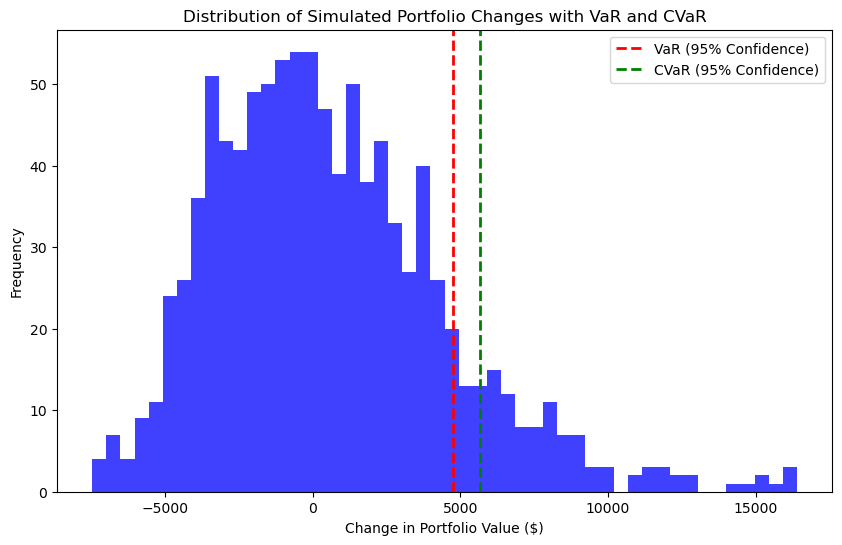

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Fetch and prepare data
ticker = 'AAPL'
data = yf.download(ticker, start="2010-01-01", end="2023-01-01")
close_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(close_prices)

# Create dataset
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 60
X, Y = create_dataset(data_scaled, look_back)
X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshaping for LSTM

# Split data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# LSTM model setup
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(look_back, 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, Y_train, epochs=5, batch_size=32, verbose=1)

# Predict using the model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
predicted_prices = scaler.inverse_transform(test_predict)

# Prepare for Monte Carlo simulation
initial_predicted_price = predicted_prices[-1][0]
num_shares = 100  # Example portfolio size
initial_portfolio_value = initial_predicted_price * num_shares
annual_volatility = np.std(data['Close'].pct_change()) * np.sqrt(252)
days = 252
simulations = 1000
dt = 1 / days

# Simulate future stock prices
np.random.seed(42)
monte_carlo_sims = np.zeros((days + 1, simulations))
monte_carlo_sims[0] = initial_predicted_price
for t in range(1, days + 1):
    random_shocks = np.random.normal(0, 1, simulations)
    monte_carlo_sims[t] = monte_carlo_sims[t - 1] * np.exp((annual_volatility * np.sqrt(dt) * random_shocks))

# Calculate VaR and CVaR
portfolio_changes = (monte_carlo_sims[-1] - initial_predicted_price) * num_shares
confidence_level = 0.95
sorted_changes = np.sort(portfolio_changes)
var_index = int((1 - confidence_level) * simulations)
value_at_risk = -sorted_changes[var_index]
conditional_value_at_risk = -np.mean(sorted_changes[:var_index])

# Output the results
print(f"Initial Portfolio Value: ${initial_portfolio_value:.2f}")
print(f"Value at Risk (VaR) at {int(confidence_level * 100)}% confidence: ${value_at_risk:.2f}")
print(f"Conditional Value at Risk (CVaR) at {int(confidence_level * 100)}% confidence: ${conditional_value_at_risk:.2f}")

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(portfolio_changes, bins=50, alpha=0.75, color='blue')
plt.axvline(value_at_risk, color='red', linestyle='dashed', linewidth=2, label='VaR (95% Confidence)')
plt.axvline(conditional_value_at_risk, color='green', linestyle='dashed', linewidth=2, label='CVaR (95% Confidence)')
plt.title('Distribution of Simulated Portfolio Changes with VaR and CVaR')
plt.xlabel('Change in Portfolio Value ($)')
plt.ylabel('Frequency')
plt.legend()
plt.show()
